In [1]:
import numpy as np
import torch
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import time

In [2]:
#the dimension of all intermediate outputs in the model
d_model = 512
#the number of attention heads
h = 8

In [3]:
def softmax(array):
    """
    Applies softmax function along the rows of the array of dimension (N, n, m), N is the batch size
    Args:
        array (torch.Tensor): torch.Tensor with dimension (N, n, m), N is the batch size
    Returns:
        torch.Tensor: Output tensor of dimension (N, n, m), N is the batch size
    """
    #print("softmax Inp: ", array.shape)
    expand_dim = array.shape[-1]    
    deno = torch.sum(torch.exp(array), axis=2)[:,None].permute(0, 2, 1).expand(-1,-1,expand_dim)
    #print("softmax out: ", (torch.exp(array)/deno).shape)
    return torch.exp(array)/deno

In [4]:
def get_accuracy(outputs, labels):
    """
    Computes accuracy of the model output against the ground truth labels
    Args:
        outputs (torch.Tensor): model outputs of dimension (N, sequence_length, self.target_vocab)
        labels (torch.Tensor): ground truth labels of dimension (N, sequence_length)
    Returns:
        torch.tensor: accuracy
    """
    #print("get_accuracy inp: ", outputs.shape)
    #print("get_accuracy inp: ", labels.shape)
    _, preds = torch.max(outputs, dim=2)
    #print("get_accuracy inp: ", (torch.tensor(torch.sum(preds == labels).item() / preds.numel())).shape)
    return torch.tensor(torch.sum(preds == labels).item() / preds.numel())

In [5]:
def single_head_attention(query, key, value, apply_mask=False, mask=None):
    """
    Perform forward single head attention operation on the given queries, keys and values
    Args:
        query (torch.Tensor): torch.Tensor with dimension (N, sequence_length, d_model//h), where h is the no of heads and N is batch size
        key (torch.Tensor): torch.Tensor with dimension (N, sequence_length, d_model//h), where h is the no of heads and N is batch size
        value (torch.Tensor): torch.Tensor with dimension (N, sequence_length, d_model//h), where h is the no of heads and N is batch size
    Returns:
        torch.Tensor: torch.Tensor with dimension (N, sequence_length, d_model//h), where h is the no of heads and N is batch size
    """
    #print("SHA inp shape: ", query.shape)
    d_k = key.shape[2]
    out = torch.matmul(query, key.permute(0, 2, 1))/np.power(d_k, 0.5)
    if apply_mask:
        tmp = mask==0
        minus_inf = torch.from_numpy(np.ones((mask.shape[0], mask.shape[1]))*np.NINF)
        tmp = tmp*minus_inf
        #setting Nan values to 0
        tmp[tmp != tmp] = 0
        out = out*mask + tmp
    #print("SHA out shape: ", torch.matmul(softmax(out), value).shape)
    return torch.matmul(softmax(out), value)

In [6]:
class multi_head_attention(nn.Module):
    """
    Performs multi head attention
    Attributes:
        head_count (positive integer): #the number of attention heads
        d_model (positive integer): #the output dimension of all sub-layers in the model
        d_k (positive integer): #the dimension of keys and queries
        d_v (positive integer): #the dimension of values
        W_heads (dict): dictionary of dictionaries for each head, containing weight matrices of queries, keys and values
                        index by "Q", "K" and "V" respectively
        W_concat (dict): weight matrix of dimension (head_count*d_v, d_model)
    Methods:
        forward(self, queries, keys, values, apply_mask=False, mask=None)
            Perform forward multi head attention operation on the given queries, keys and values
    """
    def __init__(self, n_heads, d_model):
        super().__init__()
        self.head_count = n_heads
        self.d_model = d_model
        self.d_k = d_model//self.head_count
        self.d_v = d_model//self.head_count
        self.W_heads = dict()
        for i in range(self.head_count):
            self.W_heads[i] = dict()
            self.W_heads[i]["Q"] = nn.Linear(self.d_model, self.d_k).double()
            self.W_heads[i]["K"] = nn.Linear(self.d_model, self.d_k).double()
            self.W_heads[i]["V"] = nn.Linear(self.d_model, self.d_v).double()
        self.W_concat = nn.Linear(self.head_count*self.d_v, self.d_model).double()
    
    def forward(self, queries, keys, values, apply_mask=False, mask=None):
        """
        Perform forward multi head attention operation on the given queries, keys and values
        Args:
            queries (torch.Tensor): torch.Tensor with dimension (N, sequence_length, self.d_model), where N is batch size
            keys (torch.Tensor): torch.Tensor with dimension (N, sequence_length, self.d_model), where N is batch size
            values (torch.Tensor): torch.Tensor with dimension (N, sequence_length, self.d_model), where N is batch size
        Returns:
            torch.Tensor: torch.Tensor with dimension (N, sequence_length, self.d_model), where N is batch size
        """
        #print("MHA inp shape: ", queries.shape)
        concat_heads = torch.zeros(queries.shape)
        concat_heads = concat_heads.to(torch.double)
        for i in range(self.head_count):
            query = self.W_heads[i]["Q"](queries)
            key = self.W_heads[i]["K"](keys)
            value = self.W_heads[i]["V"](values)
            head = single_head_attention(query, key, value, apply_mask, mask)
            concat_heads[:, :, i*self.d_v : (i+1)*self.d_v ] = head
        #print("MHA out shape: ", self.W_concat(concat_heads).shape)
        return self.W_concat(concat_heads)

In [7]:
class ModelBase(nn.Module):
    """
    Class containing basic methods that are required for training the model
    Methods:
        training_step(batch)
            Computes the output for inputs within the batch and return the loss and accuracy on these inputs
        testing_step (batch)
            Computes the output for inputs within the batch and return the loss and accuracy on these inputs
        training_epoch_stats(batch_stats)
            Computes the mean of the training batch statistics after each epoch
        testing_epoch_stats(batch_stats)
            Computes the mean of the test batch statistics after each epoch
    """
    def training_step(self, batch):
        """
        Computes the output for inputs within the batch and return the loss and accuracy on these inputs
        Args:
            batch (object of class DataGenerator): Contains source data, target input data, target output data and target mask
        Returns:
            dict: a dict containing loss and accuracy
        """
        out = self.forward(batch)
        loss = F.cross_entropy(out.permute(0,2,1), batch.data_tgt_op.to(torch.long))
        with torch.no_grad():
            accuracy = get_accuracy(out, batch.data_tgt_op)
        return {'train_loss': loss, 'train_accuracy': accuracy}
    
    def testing_step(self, batch):
        """
        Computes the output for inputs within the batch and return the loss and accuracy on these inputs
        Args:
            batch (object of class DataGenerator): Contains source data, target input data, target output data and target mask
        Returns:
            dict: a dict containing loss and accuracy
        """
        out = self.forward(batch)
        loss = F.cross_entropy(out.permute(0,2,1), batch.data_tgt_op.to(torch.long))
        with torch.no_grad():
            accuracy = get_accuracy(out, batch.data_tgt_op)
        return {'test_loss': loss.detach(), 'test_accuracy': accuracy}
        
    def training_epoch_stats(self, batch_stats):
        """
        Computes the mean of the training batch statistics after each epoch
        Args:
            batch_stats (list): list containing dicts, one for each batch (which are outputs of training_step)
        Returns:
            dict: a dict containing loss and accuracy
        """
        n_batches = len(batch_stats)
        epoch_train_loss = sum([x['train_loss'].item() for x in batch_stats])/n_batches
        epoch_train_accuracy = sum([x['train_accuracy'].item() for x in batch_stats])/n_batches
        return {'train_loss': epoch_train_loss, 'train_accuracy': epoch_train_accuracy}    
    
    def testing_epoch_stats(self, batch_stats):
        """
        Computes the mean of the test batch statistics after each epoch
        Args:
            batch_stats (list): list containing dicts, one for each batch (which are outputs of testing_step)
        Returns:
            dict: a dict containing loss and accuracy
        """
        n_batches = len(batch_stats)
        epoch_test_loss = sum([x['test_loss'].item() for x in batch_stats])/n_batches
        epoch_test_accuracy = sum([x['test_accuracy'].item() for x in batch_stats])/n_batches
        return {'test_loss': epoch_test_loss, 'test_accuracy': epoch_test_accuracy}

In [8]:
class FFN(nn.Module):
    "Implements FFN equation"
    def __init__(self):
        super().__init__()
        self.W1 = nn.Linear(d_model, 2048).double()
        self.W2 = nn.Linear(2048, d_model).double()

    def forward(self, x):
        """
        Argument:
            x (torch.tensor): of dimension (N, sequence_length, d_model)
        Returns:
            torch.tensor: of dimension (N, sequence_length, d_model)
        """
        #print("FFN inp: ", x.shape)
        out = self.W1(x)
        out = F.relu(out)
        out = self.W2(out)
        #print("FFN out: ", out.shape)
        return out

In [9]:
class Encoder_layer(nn.Module):
    """
    contains functionality of one encoder block
    """
    def __init__(self, dropout_prob=0.1):
        super().__init__()
        self.multi_head_att = multi_head_attention(h, d_model)
        self.ffn = FFN()
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        """
        forward pass in the encoder layer
        Argument:
            x (torch.tensor): of dimension (N, self.seq_len, d_model)
        Returns:
            torch.tensor: of dimension (N, self.seq_len, d_model)
        """
        #print("Encoder inp: ", x.shape)
        x = x.to(torch.double)
        out = self.multi_head_att.forward(x, x, x)
        out = self.dropout(out)
        out = out + nn.LayerNorm([out.shape[1], out.shape[2]]).double()(out)
        
        out = self.ffn(out)
        out = self.dropout(out)
        out = out + nn.LayerNorm([out.shape[1], out.shape[2]]).double()(out)
        #print("Encoder out: ", out.shape)
        return out

In [10]:
class Decoder_layer(nn.Module):
    """
    contains functionality of one encoder block
    """
    def __init__(self, dropout_prob=0.1):
        super().__init__()
        self.multi_head_att = multi_head_attention(h, d_model)
        self.ffn = FFN()
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, dec_x, enc_x, apply_mask=False, dec_x_msk=None):
        """
        forward pass in the encoder layer
        Argument:
            dec_x (torch.tensor): of dimension (N, target_sequence_length-1, d_model)
            enc_x (torch.tensor): of dimension (N, source_sequence_length, d_model)
            apply_mask (bool): apply mask if True 
            dec_x_msk: torch.tensor of dimension (target_sequence_length-1, target_sequence_length-1) if apply_mask
        Returns:
            torch.tensor: of dimension (N, target_sequence_length-1, d_model)
        """
        #print("Decoder inp1: ", dec_x.shape)
        #print("Decoder inp2: ", enc_x.shape)
        #if apply_mask:
            #print("Decoder inp3: ", dec_x_msk.shape)
        dec_x = dec_x.to(torch.double)
        enc_x = enc_x.to(torch.double)
        out = self.multi_head_att.forward(dec_x, dec_x, dec_x, apply_mask, dec_x_msk)
        out = self.dropout(out)
        out = out + nn.LayerNorm([out.shape[1], out.shape[2]]).double()(out)
        
        out = self.multi_head_att.forward(dec_x, enc_x, enc_x)
        out = self.dropout(out)
        out = out + nn.LayerNorm([out.shape[1], out.shape[2]]).double()(out)
        
        out = self.ffn(out)
        out = self.dropout(out)
        out = out + nn.LayerNorm([out.shape[1], out.shape[2]]).double()(out)
        #print("Decoder out: ", out.shape)
        return out

In [11]:
class Embeddings(nn.Module):
    def __init__(self, dim1, dim2):
        super().__init__()
        self.embed = nn.Embedding(dim1, dim2).double()

In [12]:
def positionalEncoding(n_pos):
    """
    positional encoding
    Attributes:
        n_pos (positive integer): #positions
    Returns:
        np.array: of dimension (n_pos, d_model)
    """
    temp1 = []
    for i in range(n_pos):
        temp2 = []
        for j in range(d_model):
            temp2.append(i / np.power(10000, 2 * (j // 2) / d_model))
        temp1.append(np.array(temp2))
    PE = np.array(temp1)
    PE[:, 0::2] = np.sin(PE[:, 0::2])
    PE[:, 1::2] = np.cos(PE[:, 1::2])
    #print("PE: ", PE.shape)
    return PE

In [13]:
class Transformer(ModelBase):
    """
    Implementation of transformer using PyTorch
    """
    def __init__(self, vocab_size, seq_len, dropout_prob=0.1):
        super().__init__()
        #to include start and end tokens
        self.source_vocab = vocab_size + 2
        self.target_vocab = vocab_size + 2
        self.seq_len = seq_len + 2
        self.source_embed = Embeddings(d_model, self.source_vocab)
        self.target_embed = Embeddings(d_model, self.target_vocab)
        self.encoder1 = Encoder_layer()
        self.encoder2 = Encoder_layer()
        self.encoder3 = Encoder_layer()
        self.encoder4 = Encoder_layer()
        self.encoder5 = Encoder_layer()
        self.encoder6 = Encoder_layer()
        self.decoder1 = Decoder_layer()
        self.decoder2 = Decoder_layer()
        self.decoder3 = Decoder_layer()
        self.decoder4 = Decoder_layer()
        self.decoder5 = Decoder_layer()
        self.decoder6 = Decoder_layer()
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        """
        Perform forward operation from input to output, in Transformer
        Args:
            x (object of class DataGenerator): Contains source data, target input data, target output data and target mask
        Returns:
            torch.tensor: of dimension (N, target_sequence_len-1, self.vocab_size)
        """
        self.tgt_msk = x.data_tgt_msk
        
        self.src_query = torch.from_numpy(np.zeros((x.data_src.shape[0], x.data_src.shape[1], d_model)))
        source_map = self.source_embed.embed.weight.clone()
        #source embedding
        for batch_idx in range(x.data_src.shape[0]):
            n_source_tokens = x.data_src.shape[1]
            for token_id in range(n_source_tokens):
                self.src_query[batch_idx, token_id, :] = source_map[:, x.data_src[batch_idx, token_id]]
        #source positional encoding
        self.src_query += torch.tensor(positionalEncoding(self.seq_len))
        self.src_query = self.dropout(self.src_query)
        
        self.tgt_query = torch.from_numpy(np.zeros((x.data_tgt_ip.shape[0], x.data_tgt_ip.shape[1], d_model)))
        
        target_map = self.target_embed.embed.weight.clone()
        #target embedding
        for batch_idx in range(x.data_tgt_ip.shape[0]):
            n_target_tokens = x.data_tgt_ip.shape[1]
            for token_id in range(n_target_tokens):
                self.tgt_query[batch_idx, token_id, :] = target_map[:, x.data_tgt_ip[batch_idx, token_id]]
        #target positional encoding
        self.tgt_query += torch.tensor(positionalEncoding(self.seq_len - 1))
        self.tgt_query = self.dropout(self.tgt_query)
        
        #passing through 1st encoder
        out = self.encoder1.forward(self.src_query)
        enc1_out = out = self.dropout(out)
        #passing through 2nd encoder
        out = self.encoder2.forward(out)
        enc2_out = out = self.dropout(out)
        #passing through 3rd encoder
        out = self.encoder3.forward(out)
        enc3_out = out = self.dropout(out)
        #passing through 4th encoder
        out = self.encoder4.forward(out)
        enc4_out = out = self.dropout(out)
        #passing through 5th encoder
        out = self.encoder5.forward(out)
        enc5_out = out = self.dropout(out)
        #passing through 6th encoder
        out = self.encoder6.forward(out)
        enc6_out = out = self.dropout(out)
        
        #passing through 1st decoder
        out = self.decoder1.forward(self.tgt_query, enc1_out, apply_mask=True, dec_x_msk=self.tgt_msk)
        out = self.dropout(out)
        #passing through 2nd decoder
        out = self.decoder2.forward(out, enc2_out)
        out = self.dropout(out)
        #passing through 3rd decoder
        out = self.decoder3.forward(out, enc3_out)
        out = self.dropout(out)
        #passing through 4th decoder
        out = self.decoder4.forward(out, enc4_out)
        out = self.dropout(out)
        #passing through 5th decoder
        out = self.decoder5.forward(out, enc5_out)
        out = self.dropout(out)
        #passing through 6th decoder
        out = self.decoder6.forward(out, enc6_out)
        out = self.dropout(out)
                
        #passing through linear layer
        out = torch.matmul(out, target_map)
        #print("transformer forward out: ", out.shape)
        return out
    
    @torch.no_grad()
    def inference(self, x):
        """
        Perform inference on input in Transformer
        Args:
            x (torch.tensor): torch.tensor with dimension (S), where S is the sequence length including start and end token
        Returns:
            list: of output generated tokens
        """
        self.eval()
        self.src_query = torch.from_numpy(np.zeros((1, x.shape[0], d_model)))
        source_map = self.source_embed.embed.weight.clone()
        #source embedding
        for batch_idx in range(1):
            n_source_tokens = x.shape[0]
            for token_id in range(n_source_tokens):
                self.src_query[batch_idx, token_id, :] = source_map[:, x[token_id]]
        #source positional encoding
        self.src_query += torch.tensor(positionalEncoding(x.shape[0]))
        self.src_query = self.dropout(self.src_query)
        
        target_map = self.target_embed.embed.weight.clone()
        start_token = torch.tensor([[0]], dtype=torch.long)
        start = torch.from_numpy(np.zeros((1, 1, d_model)))
        #target embedding
        for batch_idx in range(1):
            n_target_tokens = start.shape[1]
            for token_id in range(n_target_tokens):
                start[batch_idx, token_id, :] = target_map[:, start_token[batch_idx, token_id]]
        #positional encoding
        max_tokens = 50 + x.shape[0]
        pos_encoding = torch.tensor(positionalEncoding(max_tokens))
        
        #passing through 1st encoder
        out = self.encoder1.forward(self.src_query)
        enc1_out = out = self.dropout(out)
        #passing through 2nd encoder
        out = self.encoder2.forward(out)
        enc2_out = out = self.dropout(out)
        #passing through 3rd encoder
        out = self.encoder3.forward(out)
        enc3_out = out = self.dropout(out)
        #passing through 4th encoder
        out = self.encoder4.forward(out)
        enc4_out = out = self.dropout(out)
        #passing through 5th encoder
        out = self.encoder5.forward(out)
        enc5_out = out = self.dropout(out)
        #passing through 6th encoder
        out = self.encoder6.forward(out)
        enc6_out = out = self.dropout(out)
                
        n_generated_tokens = 0
        preds = 0
        pred_seq = []
        while (preds != self.target_vocab-1) and (n_generated_tokens < max_tokens):
            dec_ip = start
            for i in range(dec_ip.shape[1]):
                dec_ip[:,i,:] = dec_ip[:,i,:] + pos_encoding[i,:]
            dec_ip = self.dropout(dec_ip)
        
            #print(self.tgt_query.shape, self.tgt_msk.shape, enc1_out.shape)
            #passing through 1st decoder
            out = self.decoder1.forward(dec_ip, enc1_out)
            out = self.dropout(out)
            #passing through 2nd decoder
            out = self.decoder2.forward(out, enc2_out)
            out = self.dropout(out)
            #passing through 3rd decoder
            out = self.decoder3.forward(out, enc3_out)
            out = self.dropout(out)
            #passing through 4th decoder
            out = self.decoder4.forward(out, enc4_out)
            out = self.dropout(out)
            #passing through 5th decoder
            out = self.decoder5.forward(out, enc5_out)
            out = self.dropout(out)
            #passing through 6th decoder
            out = self.decoder6.forward(out, enc6_out)
            out = self.dropout(out)

            #passing through linear layer
            out = torch.matmul(out, target_map)
            #print(out.shape)
            _, preds = torch.max(out, dim=2)
            #print(preds)
            #print("preds shape: ", preds.shape)
            preds = preds[0, -1]
            pred_seq.append(preds)
            n_generated_tokens += 1
            tmp = torch.zeros((1,n_generated_tokens+1,start.shape[2]))
            tmp[:,:-1,:] = start
            #print(target_map.shape)
            #print(preds)
            #print(tmp.shape)
            #print(tmp[:,-1,:].shape, target_map[:, preds].T.shape)
            tmp[0,-1,:] = target_map[:, preds].T[0]
            start = tmp
        #print("inference out: ", len(pred_seq))
        return pred_seq

In [14]:
class DataGenerator:
    """
    generates data with "n_data" datapoints, each having length "seq_len" and the values are randomly between 1 and vocab_size
    The start token is denoted by 0 and end token is denoted by vocab_size+1
    """
    def __init__(self, vocab_size, seq_len, n_data):
        self.source_vocab = vocab_size
        self.target_vocab = vocab_size
        self.seq_len = seq_len
        self.n_data = n_data
        #source input - shape (n_data, seq_len+2)
        self.data_src = torch.from_numpy(np.random.randint(1, self.source_vocab+1, size=(self.n_data, self.seq_len+2)))
        #start token
        self.data_src[:, 0] = 0
        #end token
        self.data_src[:, -1] = self.source_vocab+1
        #target input - shape (n_data, seq_len+1)
        self.data_tgt_ip = self.data_src.detach()[:, :-1]
        #target mask - shape (seq_len+1, seq_len+1)
        self.data_tgt_msk = torch.from_numpy(np.tril(np.ones(self.seq_len+1)))
        #target output - shape (n_data, seq_len+1)
        self.data_tgt_op = self.data_src.detach()[:, 1:]
        
    def get_data(self):
        return self.data

In [15]:
@torch.no_grad()
def evaluate(model, test_loader):
    """
    Evaluates testing data
    Args:
        model (__main__.Transformer): an instance of class Transformer
        test_loader (object of class DataGenerator): Contains source data, target input data, target output data and target mask
    Returns:
        function call to model.testing_epoch_stats
    """
    model.eval()
    batch = test_loader
    outputs= []
    outputs.append(model.testing_step(batch))
    return model.testing_epoch_stats(outputs)

In [16]:
def fit(n_epoch, lr, model, train_loader, test_loader, optim_func=torch.optim.SGD, momentum=0, display_msg=False, optim_name=None):
    """
    Trains the model on the given training data for "n_epoch" epochs 
    Args:
        n_epoch (natural number): number of epochs
        lr (float): learning rate
        model (__main__.Transformer): an instance of class Transformer
        train_loader (object of class DataGenerator): Contains source data, target input data, target output data and target mask
        test_loader (object of class DataGenerator): Contains source data, target input data, target output data and target mask
        optim_func (function): optimizer function. By default, torch.optim.SGD
        momemtum (float): momentum
        display_msg (bool): displays message if display_msg is True, by default False
    Returns:
        list: a list of dicts, where each dict contains training, test loss and accuracy at the end of each epoch
    """
    epoch_stats = []
    if optim_name == "ADAM":
        optimizer = optim_func(params=model.parameters(), lr=lr)
    else:
        optimizer = optim_func(params=model.parameters(), lr=lr, momentum=momentum)
    for epoch in range(n_epoch):
        #Training
        model.train()
        batch_train_stats = []
        
        batch = train_loader
        train_stats = model.training_step(batch)
        batch_train_stats.append(train_stats)
        train_stats["train_loss"].backward()
        optimizer.step()
        optimizer.zero_grad()
            
        train_epoch_stats = model.training_epoch_stats(batch_train_stats)
        
        result = evaluate(model, test_loader)
        result['train_loss'] = train_epoch_stats['train_loss']
        result['train_accuracy'] = train_epoch_stats['train_accuracy']
        if display_msg and ((epoch)%10 == 0):
            #print(f"Epoch [{epoch+1}/{n_epoch}], train_loss: {result['train_loss']:.4f}, train_accuracy: {100*result['train_accuracy']:.2f}%")
            print(f"Epoch [{epoch+1}/{n_epoch}], train_loss: {result['train_loss']:.4f}, test_loss: {result['test_loss']:.4f}", end=", ")
            print(f"train_accuracy: {100*result['train_accuracy']:.2f}%, test_accuracy: {100*result['test_accuracy']:.2f}%")
        epoch_stats.append(result)
    return epoch_stats

In [17]:
def plot_error(model_stats, optimizer_name):
    """
    plots the training error and test error plots (vs) epoch 
    Args:
        train_loss (list): list of dict containing training, test error and accuracy for each epoch
        optimizer_name (string): optimizer used to train model
    """
    plt.rcParams["figure.figsize"] = (15,3)
    plt.figure()
    plt.subplot(121)
    plt.title(f"Training loss over epochs with {optimizer_name} optimizer")
    plt.xlabel(f"Epoch")
    plt.ylabel(f"Training loss")
    train_loss = [x["train_loss"] for x in model_stats]
    plt.plot(range(1, len(train_loss)+1), train_loss)

    plt.subplot(122)
    plt.title(f"Testing loss over epochs with {optimizer_name} optimizer")
    plt.xlabel(f"Epoch")
    plt.ylabel(f"Testing loss")
    test_loss = [x["test_loss"] for x in model_stats]
    plt.plot(range(1, len(test_loss)+1), test_loss)
    
    plt.tight_layout()
    plt.show()

In [18]:
vocab_size = 10
source_vocab, target_vocab = vocab_size, vocab_size
seq_len = 8
n_data = 100
x_train = DataGenerator(vocab_size, seq_len, n_data)
x_test = DataGenerator(vocab_size, seq_len, n_data)

In [19]:
print(f"Train stats: source shape {x_train.data_src.shape}; target input shape {x_train.data_tgt_ip.shape}; target output shape {x_train.data_tgt_op.shape}; target mask shape {x_train.data_tgt_msk.shape}")
print(f"Test stats: source shape {x_test.data_src.shape}; target input shape {x_test.data_tgt_ip.shape}; target output shape {x_test.data_tgt_op.shape}; target mask shape {x_test.data_tgt_msk.shape}")

Train stats: source shape torch.Size([100, 10]); target input shape torch.Size([100, 9]); target output shape torch.Size([100, 9]); target mask shape torch.Size([9, 9])
Test stats: source shape torch.Size([100, 10]); target input shape torch.Size([100, 9]); target output shape torch.Size([100, 9]); target mask shape torch.Size([9, 9])


In [20]:
optimizer_name = "ADAM"
y = Transformer(vocab_size, seq_len)
model_stats = fit(n_epoch=200, lr=1e-5, model=y, train_loader=x_train, test_loader=x_test, optim_func=torch.optim.Adam, momentum=0, display_msg=True, optim_name=optimizer_name)

Epoch [1/200], train_loss: 54.2572, test_loss: 37.9904, train_accuracy: 8.33%, test_accuracy: 10.33%
Epoch [11/200], train_loss: 27.1936, test_loss: 9.8734, train_accuracy: 11.33%, test_accuracy: 7.00%
Epoch [21/200], train_loss: 27.2786, test_loss: 9.2706, train_accuracy: 9.89%, test_accuracy: 16.33%
Epoch [31/200], train_loss: 24.9270, test_loss: 6.7419, train_accuracy: 11.00%, test_accuracy: 21.11%
Epoch [41/200], train_loss: 23.4441, test_loss: 8.7524, train_accuracy: 13.78%, test_accuracy: 23.56%
Epoch [51/200], train_loss: 22.4429, test_loss: 11.4930, train_accuracy: 17.56%, test_accuracy: 23.67%
Epoch [61/200], train_loss: 22.2741, test_loss: 11.1991, train_accuracy: 15.22%, test_accuracy: 24.22%
Epoch [71/200], train_loss: 21.5140, test_loss: 10.3015, train_accuracy: 15.00%, test_accuracy: 25.67%
Epoch [81/200], train_loss: 21.1956, test_loss: 9.7270, train_accuracy: 15.33%, test_accuracy: 25.89%
Epoch [91/200], train_loss: 20.4604, test_loss: 9.6362, train_accuracy: 15.78%, te

In [21]:
#save model parameters
torch.save(y.state_dict(), "first_200_epochs.pth")

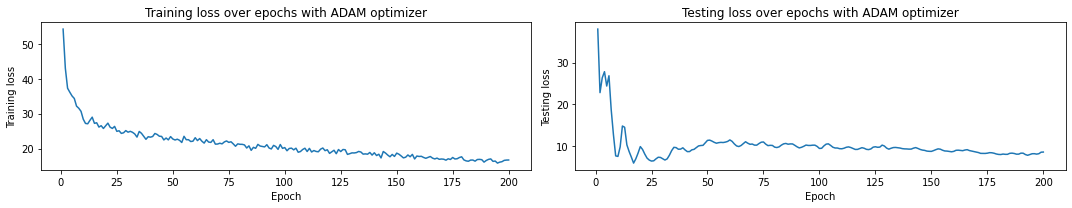

In [22]:
plot_error(model_stats, optimizer_name)

### Predicting sequence for a seen sequence in training

In [34]:
out = y.inference(x_train.data_src[0])

In [35]:
print(f"Output sequence length is {len(out)}")

Output sequence length is 60


In [36]:
print(f"The output sequence is {out}")

The output sequence is [tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5)]


### Predicting sequence for an unseen sequence

In [23]:
sample_input = [3,7,9,10,1,2,3,6,7]

In [24]:
def process_new_inputs(array):
    array = [0] + array + [source_vocab+1]
    return torch.tensor(array)

In [25]:
out = y.inference(process_new_inputs(sample_input))

In [26]:
print(f"Output sequence length is {len(out)}")

Output sequence length is 61


In [27]:
print(f"The output sequence is {out}")

The output sequence is [tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7)]


### Observation
Eventhough the loss is decreasing over iterations, the model is not learning the identity mapping between source and target sequence in both seen and unseen sequences